# HW 6 Предсказание трафика метро

## Получение датасета 

In [310]:
# Библиотеки анализа данных
import numpy as np
import pandas as pd

# Библиотеки статистического анализа
import statsmodels.api as sm

# Библиотеки машинного обучения
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Библиотеки построения диаграмм
from matplotlib import pyplot as plt
import seaborn as sns

# Установка режима отображения диаграмм
%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 5)
plt.style.use("ggplot")

Данные по загруженности метро https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

In [311]:
metro_data = pd.read_csv(filepath_or_buffer='Metro_Interstate_Traffic_Volume.csv', 
                         usecols=['traffic_volume', 'date_time', 'holiday', 'temp'],
                         parse_dates=['date_time'])

metro_data.head()

,holiday,temp,date_time,traffic_volume
0,None,288.28,2012-10-02 09:00:00,5545
1,None,289.36,2012-10-02 10:00:00,4516
2,None,289.58,2012-10-02 11:00:00,4767
3,None,290.13,2012-10-02 12:00:00,5026
4,None,291.14,2012-10-02 13:00:00,4918


traffic_volume - наша целевая переменная

date_time, holiday - является ли день некоторым праздником

temp - температура воздуха

In [312]:
metro_data.shape

(48204, 4)

In [313]:
metro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   holiday         48204 non-null  object        
 1   temp            48204 non-null  float64       
 2   date_time       48204 non-null  datetime64[ns]
 3   traffic_volume  48204 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


# EDA

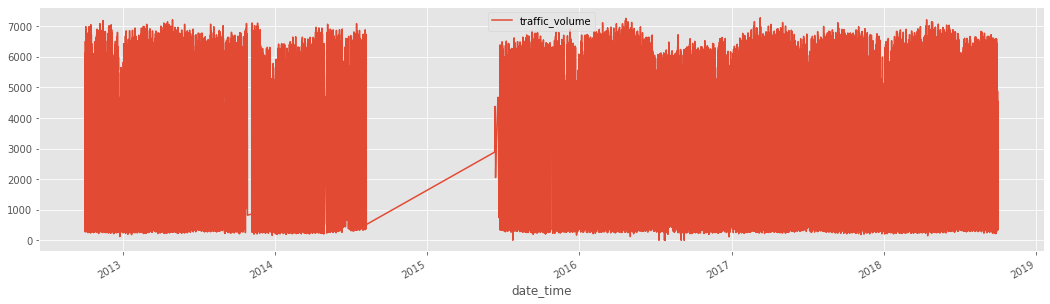

In [314]:
metro_data["date_time"] = pd.to_datetime(metro_data["date_time"])
metro_data.index = metro_data["date_time"]
metro_data.plot(x='date_time', y='traffic_volume', figsize=(18, 5))
plt.show()

Есть большой пустой промежуток в 2015 году. Оставляем данные с 2016 года

In [315]:
metro_data = metro_data[metro_data.index > '2016-01-01']

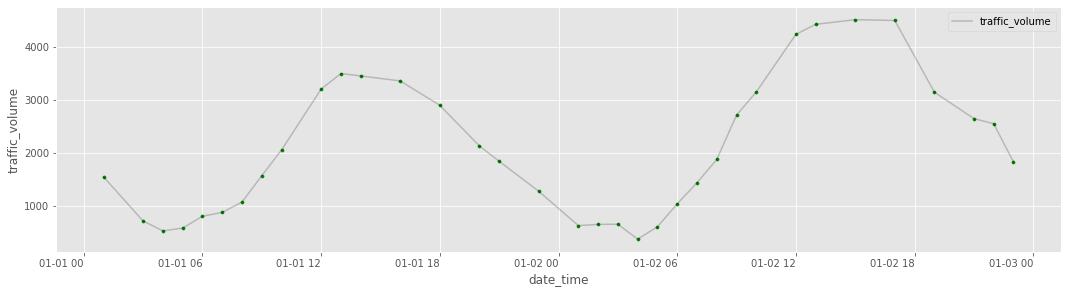

In [316]:
# Посмотрм данные за 2 дня
d2 = metro_data.loc["2016-01-01":"2016-01-02"]
ax = d2.plot(x="date_time", y="traffic_volume", color="black", alpha=0.2)
d2.plot.scatter(ax=ax, x="date_time", y="traffic_volume", color="green", s=10)


In [317]:
d2

,holiday,temp,date_time,traffic_volume
date_time,,,,
2016-01-01 01:00:00,None,266.00,2016-01-01 01:00:00,1550
2016-01-01 03:00:00,None,266.01,2016-01-01 03:00:00,719
2016-01-01 04:00:00,None,264.80,2016-01-01 04:00:00,533
2016-01-01 05:00:00,None,264.38,2016-01-01 05:00:00,586
2016-01-01 06:00:00,None,263.99,2016-01-01 06:00:00,809
2016-01-01 07:00:00,None,264.16,2016-01-01 07:00:00,882
2016-01-01 08:00:00,None,264.80,2016-01-01 08:00:00,1077
2016-01-01 09:00:00,None,265.76,2016-01-01 09:00:00,1574
2016-01-01 10:00:00,None,267.61,2016-01-01 10:00:00,2059


In [318]:
#metro_data["holiday"].value_counts().to_frame()

In [319]:
metro_data.duplicated().value_counts()

False    23137
True      4721
dtype: int64

Есть дубликаты и нарушена равномерность временных интервалов, т.е. не все значения отстоят друг от друга на 1 час - дубликаты удаляем, а временные интервалы выравниваем и заполняем пропуски при помощи линейной интерполяции

In [320]:
# Восстановление равномерности временных интервалов и заполнение образовавшихся пропусков
metro_df = metro_data.drop_duplicates()
metro_df = metro_df.resample('H').min().interpolate(method='piecewise_polynomial')
metro_df = metro_df[['traffic_volume', 'holiday', 'temp']]

In [321]:
metro_df.duplicated().value_counts()

False    24074
True        21
dtype: int64

### Создание новых признаков

In [322]:
# Кодирование времени суток с помощью sin и cos (циферблат)
metro_df['weekday'] = metro_df.index.weekday
metro_df["month"] = metro_df.index.month
metro_df["hour"] = metro_df.index.hour
metro_df["is_weekend"] = metro_df.index.weekday.isin([5,6]).astype(int)
metro_df["holiday"] = metro_df["holiday"].apply(lambda x: 0 if x == "None" else 1)
metro_df['hour_sin'] = np.sin(2 * np.pi * metro_df['hour'].values / 23)
metro_df['hour_cos'] = np.cos(2 * np.pi * metro_df['hour'].values / 23)


# Расчет среднего значения трафика по часам и по дням
traffic_mean = metro_df.groupby(['weekday', 'hour'])['traffic_volume'].mean().reset_index()
metro_df = metro_df.reset_index().merge(traffic_mean, on=['weekday', 'hour'], suffixes=['', '_mean'])
metro_df = metro_df.set_index('date_time').sort_index()

    
# Преобразование категориальных признаков в фиктивные переменные 
# Проверил, что достаточно одного признака Праздник, без разбивки на типы, на точность модели это не влияет
#metro_df = pd.get_dummies(metro_df, columns=['holiday'])
#metro_df.columns = metro_df.columns.str.replace(' ', '')




In [323]:
metro_df

,traffic_volume,holiday,temp,weekday,month,hour,is_weekend,hour_sin,hour_cos,traffic_volume_mean
date_time,,,,,,,,,,
2016-01-01 01:00:00,1550.0,0,266.000,4,1,1,0,2.697968e-01,0.962917,471.521991
2016-01-01 02:00:00,1134.5,1,266.005,4,1,2,0,5.195840e-01,0.854419,359.113426
2016-01-01 03:00:00,719.0,0,266.010,4,1,3,0,7.308360e-01,0.682553,396.531250
2016-01-01 04:00:00,533.0,0,264.800,4,1,4,0,8.878852e-01,0.460065,862.829861
2016-01-01 05:00:00,586.0,0,264.380,4,1,5,0,9.790841e-01,0.203456,2660.135417
...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,0,283.450,6,9,19,1,-8.878852e-01,0.460065,3170.924769
2018-09-30 20:00:00,2781.0,0,282.760,6,9,20,1,-7.308360e-01,0.682553,2803.444444
2018-09-30 21:00:00,2159.0,0,282.730,6,9,21,1,-5.195840e-01,0.854419,2377.576389


In [324]:
d2 = metro_df.loc["2016-01-01":"2016-01-02"]
d2.head()

,traffic_volume,holiday,temp,weekday,month,hour,is_weekend,hour_sin,hour_cos,traffic_volume_mean
date_time,,,,,,,,,,
2016-01-01 01:00:00,1550.0,0,266.000,4,1,1,0,0.269797,0.962917,471.521991
2016-01-01 02:00:00,1134.5,1,266.005,4,1,2,0,0.519584,0.854419,359.113426
2016-01-01 03:00:00,719.0,0,266.010,4,1,3,0,0.730836,0.682553,396.531250
2016-01-01 04:00:00,533.0,0,264.800,4,1,4,0,0.887885,0.460065,862.829861
2016-01-01 05:00:00,586.0,0,264.380,4,1,5,0,0.979084,0.203456,2660.135417


In [325]:
# Функция для разбивки временного ряда на тренировочную и тестовую выборку
def timeseries_train_test_split(X_array, Y_array, test_number_week=2):
    train_idx = X_array.index < (X_array.index.max() - pd.Timedelta(str(test_number_week) + 'W'))
    
    X_train = X_array[train_idx]
    X_test = X_array[~train_idx]
    Y_train = Y_array[train_idx]
    Y_test = Y_array[~train_idx]

    return X_train, X_test, Y_train, Y_test

In [326]:
# Разбиение данных на тренировочную и тестовую выборку
X_train, X_test, Y_train, Y_test = timeseries_train_test_split(
    metro_df.iloc[:, 1:], metro_df.iloc[:, 0], 2)

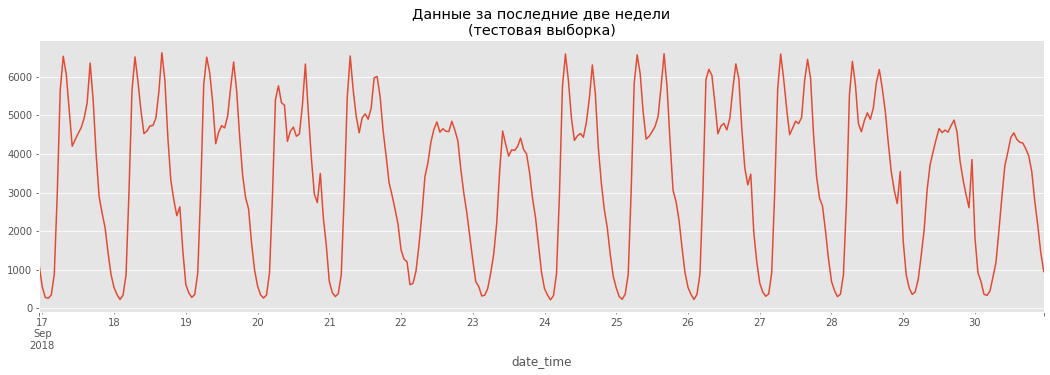

In [327]:
# Вывод данных за последние две недели
Y_test.plot()
plt.title('Данные за последние две недели\n(тестовая выборка)')
plt.show()

## Прогнозирование

In [328]:
# Функция построения текущего временного ряда с прогнозом, доверительным интервалом и выбросами
def plot_model(model, X_train, X_test, Y_train, Y_test, intervals=False, plot_anomalies=False, title=''):

    train_idx = range(len(X_train))
    test_idx = range(len(X_train), len(X_train) + len(X_test))
    
    # Вывод текущего временного ряда и его прогноза
    Y_pred = model.predict(X_test)
    
    plt.figure(figsize=(18, 5))
    plt.plot(test_idx, Y_test.values, label='Реальные значения')
    plt.plot(test_idx, Y_pred, 'g', label='Прогнозные значения', linewidth=2.0)
    
    # Вывод доверительного интервала
    if intervals:
        scale = 1.96
        cv = cross_val_score(model, X_train, Y_train, cv=TimeSeriesSplit(), scoring='neg_mean_absolute_error')
        mae = cv.mean() * (-1)
        lower_bound = Y_pred - (mae + scale * mae.std())
        upper_bound = Y_pred + (mae + scale * mae.std())
    
        plt.plot(test_idx, lower_bound, 'r--', label='Границы доверительного интервала', alpha=0.5)
        plt.plot(test_idx, upper_bound, 'r--', alpha=0.5)
    
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(Y_test))
            anomalies[Y_test<lower_bound] = Y_test[Y_test<lower_bound]
            anomalies[Y_test>upper_bound] = Y_test[Y_test>upper_bound]
            plt.plot(test_idx, anomalies, "o", markersize=10, label = "Аномалии")
    # Вывод оценки качества прогноза модели
    error = r2_score(Y_pred, Y_test)
    plt.title(title + ', R2 = {0:.3f}'.format(error))
    #error = mean_absolute_percentage_error(Y_pred, Y_test)
    #plt.title(title + ', MAPE = {0:.3f}%'.format(error))
    
    # Вывод легенды
    plt.legend(loc='best')
    plt.show()

In [329]:
# Функция вывода коэффициентов модели в порядке их значимости
def plot_coefficients(coefs, X_array):
    # Определение коэффициентов модели
    coefs_df = pd.DataFrame(coefs, X_array.columns, columns=['coef'])
    coefs_df['coef_abs'] = coefs_df.coef.abs()
    coefs_df = coefs_df.sort_values('coef_abs', ascending=False)
    
    # Вывод коэффициентов модели
    plt.figure(figsize=(8, 5))
    plt.bar(coefs_df.index, coefs_df.coef)
    plt.title('Коэффициенты модели')
    plt.xticks(rotation=90)
    plt.show()

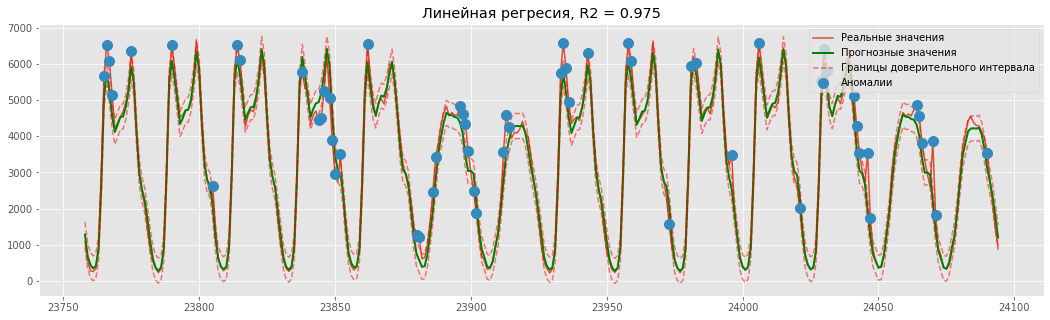

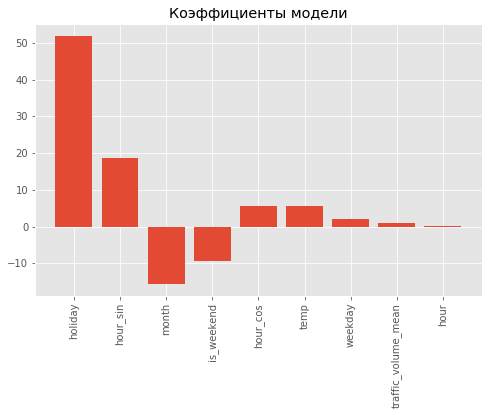

In [338]:
# Построение прогноза временного ряда с помощью линейной регрессии
lr_model = LinearRegression().fit(X_train, Y_train)
plot_model(lr_model, X_train, X_test, Y_train, Y_test, intervals=True, plot_anomalies=True, title='Линейная регресия')
plot_coefficients(lr_model.coef_, X_test)

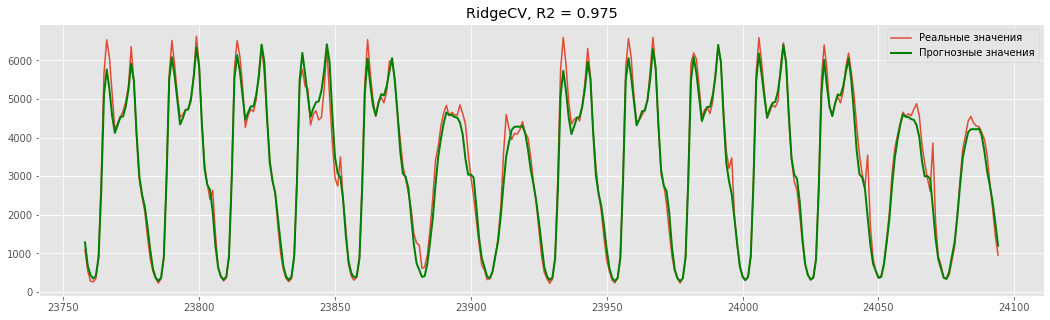

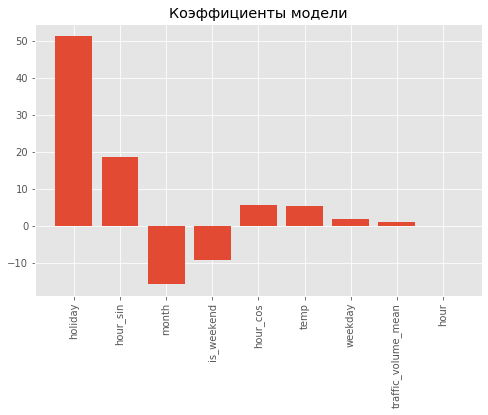

In [339]:
# Построение прогноза временного ряда с помощью Ridge регрессии
rd_model = RidgeCV(cv=TimeSeriesSplit()).fit(X_train, Y_train)
plot_model(rd_model, X_train, X_test, Y_train, Y_test, title='RidgeCV')
plot_coefficients(rd_model.coef_, X_test)


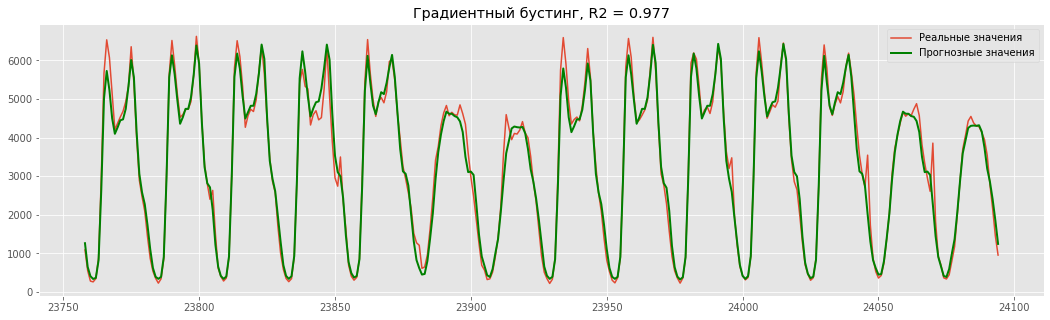

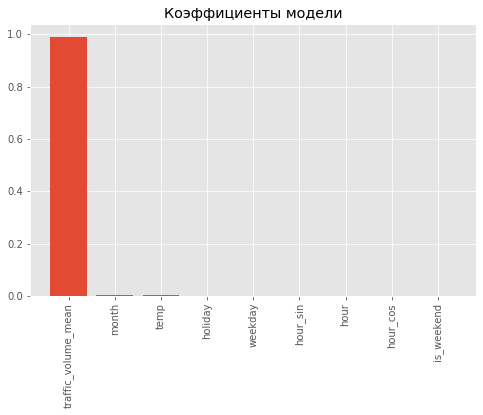

In [337]:
# Построение прогноза временного ряда с помощью градиентного бустинга
gb_model = GradientBoostingRegressor().fit(X_train, Y_train)
plot_model(gb_model, X_train, X_test, Y_train, Y_test, title='Градиентный бустинг')
plot_coefficients(gb_model.feature_importances_, X_test)

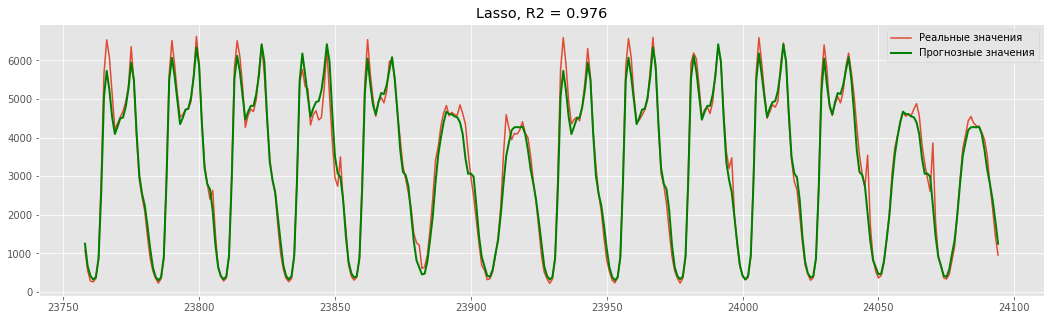

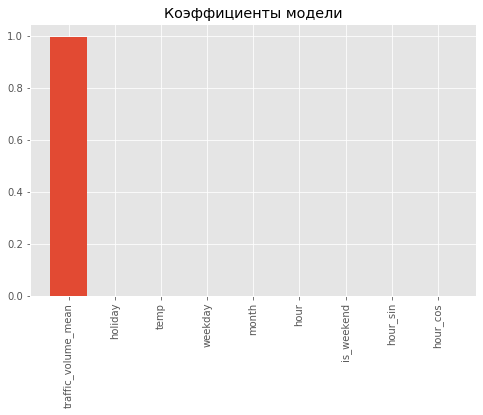

In [333]:
# Построение прогноза временного ряда с помощью Lasso
ls_model = LassoCV(cv=TimeSeriesSplit()).fit(X_train, Y_train)
plot_model(ls_model, X_train, X_test, Y_train, Y_test, title='Lasso')
plot_coefficients(ls_model.coef_, X_test)

## Модель SARIMAX

In [334]:
# Функция построения прогноза временного ряда с помощью модели SARIMAX
def plot_SARIMAX(model, Y_test, s=168, d=1, n_steps=0, title=''):
    # Определение прогноза модели SARIMAX
    Y_pred = model.fittedvalues
    Y_pred[:s+d] = np.NaN
    
    # Определение необходимости в прогнозе будущего периода времени 
    if n_steps > 0:
        forecast = model.get_forecast(steps=n_steps)
        Y_forecast = Y_pred.append(forecast.predicted_mean)
    else:
        Y_forecast = Y_pred
    
    # Построение текущего временного ряда и прогнозных значений
    plt.figure(figsize=(18, 5))
    plt.plot(Y_test.values, label = 'Реальные значения')
    plt.plot(Y_forecast.values, color='g', label='Прогнозные значения', linewidth=2.0)
    
    # Вывод оценки прогноза модели
    error = r2_score(Y_pred[s+d:], Y_test[s+d:])
    plt.title(title + ', R2 = {0:.3f}'.format(error))
    #error = mean_squared_error(Y_pred, Y_test)
    #plt.title(title + '\n Ошибка MSE = {0:.3f}%'.format(error))
    
    # Вывод прогноза и доверительного интервала для будущего периода времени
    if n_steps > 0:
        intervals = forecast.conf_int(alpha=0.2)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Границы доверительного интервала")
        #plt.fill_between(intervals.index, intervals['upper'], intervals['lower'], alpha=0.1, color = "grey")
    
    # Вывод легенды
    plt.legend(loc='upper left')
    plt.show()

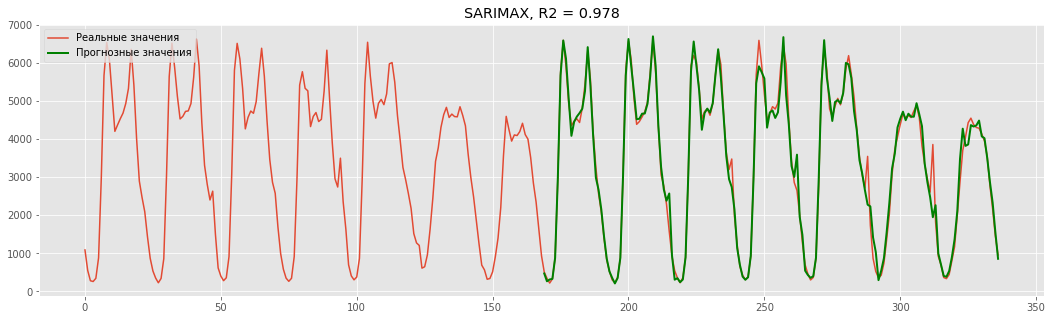

In [335]:
# Построение прогноза с помощью SARIMAX модели
sarimax_model = sm.tsa.SARIMAX(Y_test.reset_index(drop=True), order=(1, 1, 1), seasonal_order=(0, 1, 0, 24*7)).fit()
plot_SARIMAX(sarimax_model, Y_test, title='SARIMAX')

### Прогноз на следующу неделю

Модель SARIMAX оказалась более точная, используем ее для пронощирования на следующую неделю

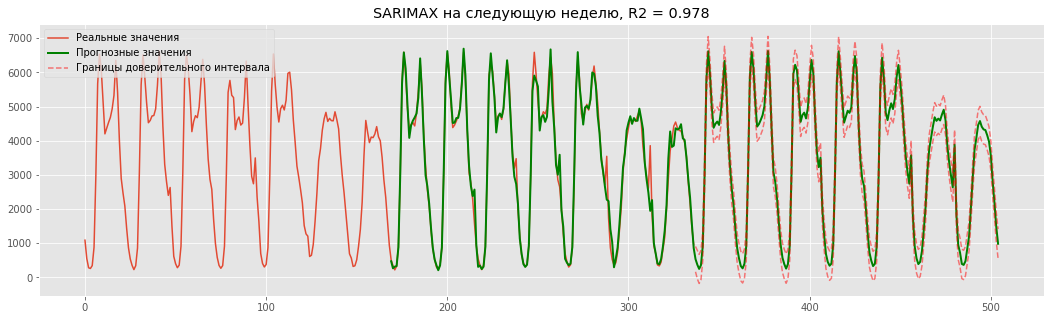

In [336]:
# Построение прогноза на следующую неделю с помощью модели SARIMAX
plot_SARIMAX(sarimax_model, Y_test, n_steps=24*7, title='SARIMAX на следующую неделю')

### Выводы

Модель SARIMAX оказалась более точной, чем остальные модели. Эта модель использовалась для построения прогноза на следующую неделю и построения доверительного интервала для этого прогноза.

Но модель SARIMAX оказалась значительно медлее остальных моделей. 

Градиентый бустинг показал практически такую же точность, что и SARIMAX модель, но был на порядок быстрее в прогнозировании. 